In [1]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt

In [2]:
file_path = "../Data/goat-bench/sarcasm/sarcasm/test.jsonl"

json_objects = []

with open(file_path, 'r') as file:
    # Read each line in the file
    for line in file:
        # Parse the JSON object in the line
        json_object = json.loads(line)
        # Append the parsed JSON object to the list
        json_objects.append(json_object)

# Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(json_objects)

# Display the DataFrame
df

,id,img,label,text
0,862902619928506372,862902619928506372.jpg,1,i am guessing # netflix no longer lets you gra...
1,892551658487631873,892551658487631873.jpg,1,it 's the insensitive strikeouts at suntrust p...
2,853143461360480256,853143461360480256.jpg,1,"following the path of the river calder , so ....."
3,918423568823840768,918423568823840768.jpg,1,# westernsahara # authority has no lessons 2ge...
4,731617467718610944,731617467718610944.jpg,1,hey <user> great sale !
...,...,...,...,...
1815,820411692106584064,820411692106584064.jpg,0,* smashes everything *
1816,819327594612985856,819327594612985856.jpg,0,why does this have me dying ? !
1817,823315070423797760,823315070423797760.jpg,0,up next - last match of the day # eleaguemajor...
1818,816795819336577024,816795819336577024.jpg,0,we had a great 1st quarter ! big thx to all do...


In [3]:
df['img_path'] = df['img'].apply(lambda x: "/kaggle/input/goat-bench/sarcasm/sarcasm/images/" + x) # Create new column named img_path to store the full path of the image
# replacing 0 with non-hateful and 1 with hateful
mapping = {"0": 'non-sarcasm', "1": 'sarcasm'}
df['label'] = df['label'].replace(mapping)

df = df.drop(['img', 'id'], axis=1) #drop unnecessary columns
df = df[df['text'] != 'null'] # some columns have "null" in the text. deleting them
df = df.sample(frac=1) #randomize
df = df[:600] #take only 600 images
df

,label,text,img_path
770,sarcasm,like father like son . # teenwolf emoji_15 em...,/kaggle/input/goat-bench/sarcasm/sarcasm/image...
307,sarcasm,stop bashing jed york ; he has worked hard to ...,/kaggle/input/goat-bench/sarcasm/sarcasm/image...
1393,non-sarcasm,# captainamerica as an orc ? heck yeah ! meet ...,/kaggle/input/goat-bench/sarcasm/sarcasm/image...
714,sarcasm,ha ha .. hit like if you have faced a similar ...,/kaggle/input/goat-bench/sarcasm/sarcasm/image...
1089,non-sarcasm,this is a rare sehun and ten picture it will o...,/kaggle/input/goat-bench/sarcasm/sarcasm/image...
...,...,...,...
222,sarcasm,<user> version of what # raindontcome and <us...,/kaggle/input/goat-bench/sarcasm/sarcasm/image...
1354,non-sarcasm,“ denmark isn 't ready for a queen like me . ”...,/kaggle/input/goat-bench/sarcasm/sarcasm/image...
1645,non-sarcasm,"michael "" power mike "" okpala , a former niger...",/kaggle/input/goat-bench/sarcasm/sarcasm/image...
39,sarcasm,it 's strange ... i don 't ever remember seein...,/kaggle/input/goat-bench/sarcasm/sarcasm/image...


In [4]:
df['img_path'] = df['img_path'].apply(lambda x: x.replace("/kaggle/input", "../Data"))
df.head()

,label,text,img_path
770,sarcasm,like father like son . # teenwolf emoji_15 em...,../Data/goat-bench/sarcasm/sarcasm/images/9109...
307,sarcasm,stop bashing jed york ; he has worked hard to ...,../Data/goat-bench/sarcasm/sarcasm/images/8159...
1393,non-sarcasm,# captainamerica as an orc ? heck yeah ! meet ...,../Data/goat-bench/sarcasm/sarcasm/images/8204...
714,sarcasm,ha ha .. hit like if you have faced a similar ...,../Data/goat-bench/sarcasm/sarcasm/images/7239...
1089,non-sarcasm,this is a rare sehun and ten picture it will o...,../Data/goat-bench/sarcasm/sarcasm/images/8175...


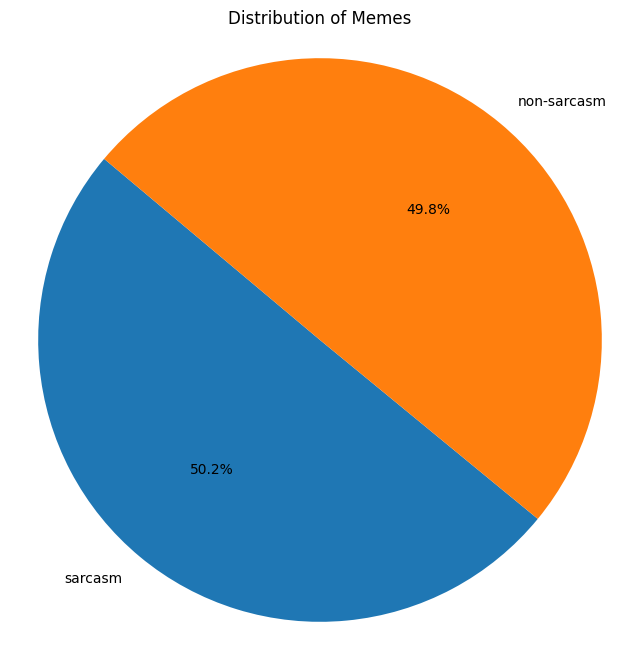

In [5]:
label_counts = df['label'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Memes')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

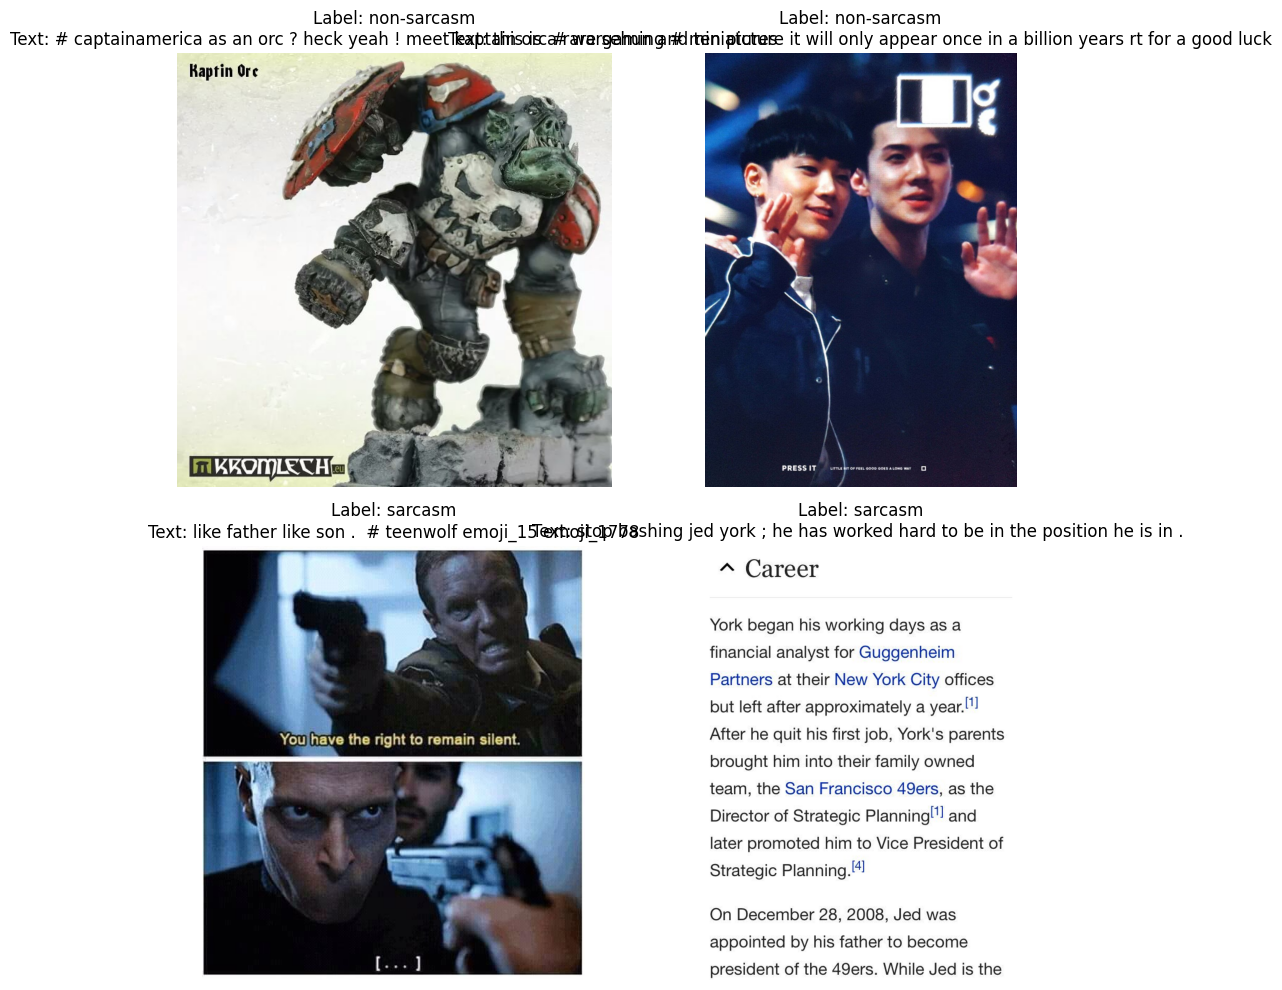

In [6]:
import cv2
grouped = df.groupby('label')

# Initialize figure
fig = plt.figure(figsize=(10, 10))

# Iterate through each group
for i, (_, group) in enumerate(grouped):
    # Display two images from each group
    for j, (text, img_path) in enumerate(zip(group['text'][:2], group['img_path'][:2])):
        # Read image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Display image
        ax = fig.add_subplot(len(grouped), 2, i * 2 + j + 1)
        ax.imshow(img)
        ax.set_title(f"Label: {group.iloc[j]['label']}\nText: {text}")
        ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
import requests
from PIL import Image
from transformers import LlavaProcessor, LlavaForConditionalGeneration

checkpoint = "Intel/llava-gemma-2b"

# Load processor
processor = LlavaProcessor.from_pretrained(checkpoint)

# Prepare inputs
# Use gemma chat template

# Generate
model = LlavaForConditionalGeneration.from_pretrained(checkpoint)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00,  7.11it/s]


In [9]:
%%time
all_response=[] # save all responses
for i in range(len(df)):
    image = Image.open(df.iloc[i]['img_path']).convert('RGB') # load the image
    text_=df.iloc[i]['text'] # getting the corresponding text of the meme
    content = f"Given the meme, with the text: {text_}; accompanied by the image <image>, is this meme a sarcasm?" #  this is the prompt. it is the same as the paper
    prompt = processor.tokenizer.apply_chat_template(
        [{'role': 'user', 'content': content}],
        tokenize=False,
        add_generation_prompt=False
    )  # defining the porompt as the model takes
    inputs = processor(text=prompt, images=image, return_tensors="pt")   # preprocessed output
    generate_ids = model.generate(**inputs, max_new_tokens=30) # the generated ids (tensor) that is basically a text in number format
    output = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0] # converting the number into actual text
    output = output.split("is this meme a sarcasm?")[-1] # getting the result. the model returns both input and output. we are splitting the output part
    all_response.append(output) #saving the output

    print(i,end =" ")

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.


0 1 2 3 4 5 

KeyboardInterrupt: 

In [10]:
df['descriptions']=all_response
df.to_csv("sarcasm_with_description.csv",index=False)
df

ValueError: Length of values (6) does not match length of index (600)

In [ ]:
import chromadb
client = chromadb.Client()
collection = client.create_collection("classification")

harmful = "this is sarcasm text. It conveys a sercastic message and people may find it funny." # defining what a harmful text is
non_harmful = "this is not a sarcasm. This is a nutral text. It conveys a positive or nutral message." # defining what a non - harmful text is

In [ ]:
collection.add(
    documents=[harmful, non_harmful],
    metadatas=[{"category": "sarcasm"}, {"category": "non-sarcasm"}],
    ids=["sarcasm", "non-sarcasm"]
) #defining the chromadb collection

In [ ]:
results = collection.query(
      query_texts=all_response,
      n_results=1
)

In [ ]:
y_true = list(df['label'])
y_pred= []

In [ ]:
for i in range(len(all_response)):
    y_pred.append(results['ids'][i][0])

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, pos_label='non-sarcasm')
recall = recall_score(y_true, y_pred, pos_label='non-sarcasm')
f1 = f1_score(y_true, y_pred, pos_label='non-sarcasm')
mcc = matthews_corrcoef(y_true, y_pred)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("MCC:", mcc)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False,
            xticklabels=['Sarcasm', 'Non-sarcasm'],
            yticklabels=['Sarcasm', 'Non-sarcasm'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()